In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
import pickle
from collections import Counter
import pandas as pd
import os
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, BatchSampler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import seaborn as sns
import math
import time
import torchvision.transforms as T

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!pip install pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 2.2 MB/s eta 0:00:00


In [5]:
data_path = "/content/drive/MyDrive/custom_captions_dataset/"

class Vocabulary(object):
    def __init__(self,
                 vocab_threshold,
                 vocab_file='./vocab.pkl',
                 start_word="<start>",
                 end_word="<end>",
                 unk_word="<unk>",
                 data_folder='../custom_captions_dataset/',
                 vocab_from_file=False):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.data_folder = data_folder
        self.vocab_from_file = vocab_from_file
        self.fetch_vocab()

    def fetch_vocab(self):
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def initialize_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    def build_vocab(self):
        self.initialize_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.new_captions()


    def new_captions(self):
        counter = Counter()

        # Load the training data CSV file
        caps_Df = pd.read_csv(os.path.join(self.data_folder, 'train.csv'))

        for idx, caption in enumerate(caps_Df['caption']):
            toks = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(toks)

            if idx % 1000 == 0:
                print(f"[{idx}/{len(caps_Df)}] Tokenizing captions...")

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1


    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


In [6]:
class Caption_dataset(Dataset):
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word,
                 end_word, unk_word, data_folder, vocab_from_file):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
                                end_word, unk_word, data_folder, vocab_from_file)
        self.img_folder = os.path.join(data_folder, mode)

        self.captions_file = pd.read_csv(os.path.join(data_folder, f'{mode}.csv'))
        self.img_paths = self.captions_file['filename'].values
        self.captions = self.captions_file['caption'].values

        print('Obtaining caption lengths...')
        self.caption_lengths = [len(nltk.tokenize.word_tokenize(str(caption).lower())) for caption in tqdm(self.captions)]

    def get_train_indices(self):
        length = np.random.choice(self.caption_lengths)
        all_indices = [i for i, lenc in enumerate(self.caption_lengths) if lenc == length]
        indices = list(np.random.choice(all_indices, size=min(len(all_indices), self.batch_size), replace=False))
        return indices

    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder, self.img_paths[index])
        img = Image.open(img_path).convert('RGB')
        orig_img = np.array(img)
        if self.transform:
            img = self.transform(img)

        caption = self.captions[index]
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption_tokens = []
        caption_tokens.append(self.vocab(self.vocab.start_word))
        caption_tokens.extend([self.vocab(token) for token in tokens])
        caption_tokens.append(self.vocab(self.vocab.end_word))
        caption_tokens = torch.tensor(caption_tokens, dtype=torch.long)
        if self.mode == 'train':
          return img, caption_tokens
        else:
          print("is invoked")
          return orig_img,img,caption_tokens


    def __len__(self):
        return len(self.img_paths)


In [7]:
data_path = "/content/drive/MyDrive/custom_captions_dataset/"

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               data_folder='./custom_dataset'):

    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if not vocab_from_file: assert mode == 'train', "To generate vocab from captions file, must be in training mode (mode='train')."

    if vocab_from_file: assert os.path.exists(vocab_file), "vocab_file does not exist. Change vocab_from_file to False to create vocab_file."

    vocab = None
    dataset = Caption_dataset(transform=transform,
                                   mode=mode,
                                   batch_size=batch_size,
                                   vocab_threshold=vocab_threshold,
                                   vocab_file=vocab_file,
                                   start_word=start_word,
                                   end_word=end_word,
                                   unk_word=unk_word,
                                   data_folder=data_folder,
                                   vocab_from_file=vocab_from_file)

    if mode != 'train':
        load_Data = DataLoader(dataset=dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers)
    else:
        indices = dataset.get_train_indices()
        initial_sampler = SubsetRandomSampler(indices)
        load_Data = DataLoader(dataset=dataset,
                                 num_workers=num_workers,
                                 batch_sampler=BatchSampler(sampler=initial_sampler,
                                                            batch_size=batch_size,
                                                            drop_last=False))

    return load_Data

In [8]:

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

vocab_threshold = 5

batch_size = 64

data_folder = data_path

data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         data_folder=data_folder)

[0/5715] Tokenizing captions...
[1000/5715] Tokenizing captions...
[2000/5715] Tokenizing captions...
[3000/5715] Tokenizing captions...
[4000/5715] Tokenizing captions...
[5000/5715] Tokenizing captions...
Obtaining caption lengths...


100%|██████████| 5715/5715 [00:08<00:00, 689.25it/s]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

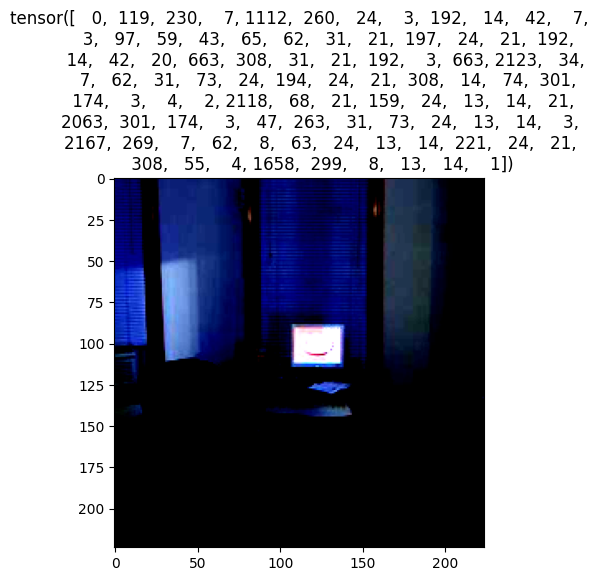

In [11]:

def display_img(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.pause(0.001)

imgs, captions = next(iter(data_loader))

imgs = imgs.numpy()

display_img(np.transpose(imgs[0], (1, 2, 0)), captions[0])


In [12]:
print(data_loader.dataset.vocab("windows"))
print(data_loader.dataset.vocab("abadafd"))

sample_cap = 'A person doing a trick on a rail while riding a skateboard.'
sample_toks = nltk.tokenize.word_tokenize(str(sample_cap).lower())
print(sample_toks)
sample_cap = []
start_word = data_loader.dataset.vocab.start_word
end_word = data_loader.dataset.vocab.end_word
sample_cap.append(data_loader.dataset.vocab(start_word))
sample_cap.extend([data_loader.dataset.vocab(token) for token in sample_toks])
sample_cap.append(data_loader.dataset.vocab(end_word))
print(sample_cap)

308
2
['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']
[0, 3, 270, 928, 3, 929, 8, 3, 1540, 643, 347, 3, 79, 14, 1]


In [13]:
print('Total number of tokens in the vocabulary=', len(data_loader.dataset.vocab))

Total number of tokens in the vocabulary= 2553


In [14]:
vocab_threshold = 4

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         data_folder=data_folder)

[0/5715] Tokenizing captions...
[1000/5715] Tokenizing captions...
[2000/5715] Tokenizing captions...
[3000/5715] Tokenizing captions...
[4000/5715] Tokenizing captions...
[5000/5715] Tokenizing captions...
Obtaining caption lengths...


100%|██████████| 5715/5715 [00:05<00:00, 1003.33it/s]


In [15]:
print('Total number of tokens in vocabulary=', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary= 2937


In [16]:
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True,
                         data_folder=data_folder)


Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 5715/5715 [00:05<00:00, 1122.10it/s]


In [17]:
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 2937


In [18]:
from collections import Counter
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d <===> count: %5d' % (value, count))

value: 74 <===> count:   170
value: 72 <===> count:   168
value: 73 <===> count:   151
value: 71 <===> count:   145
value: 78 <===> count:   145
value: 75 <===> count:   144
value: 69 <===> count:   143
value: 70 <===> count:   143
value: 77 <===> count:   131
value: 76 <===> count:   130
value: 37 <===> count:   108
value: 68 <===> count:   106
value: 80 <===> count:   103
value: 36 <===> count:   100
value: 79 <===> count:    99
value: 67 <===> count:    99
value: 83 <===> count:    95
value: 82 <===> count:    93
value: 35 <===> count:    90
value: 39 <===> count:    89
value: 65 <===> count:    88
value: 66 <===> count:    86
value: 33 <===> count:    86
value: 32 <===> count:    83
value: 86 <===> count:    82
value: 38 <===> count:    80
value: 41 <===> count:    79
value: 81 <===> count:    78
value: 42 <===> count:    77
value: 64 <===> count:    77
value: 34 <===> count:    77
value: 40 <===> count:    76
value: 85 <===> count:    72
value: 30 <===> count:    70
value: 84 <===

<ipython-input-19-a69f0b40d332>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths, kde=False, bins=20)


<Axes: >

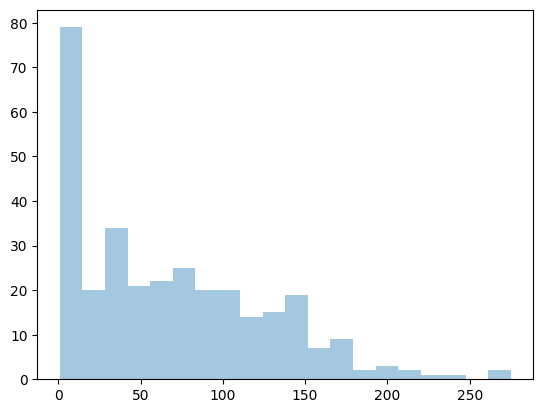

In [19]:
sns.distplot(lengths, kde=False, bins=20)

In [20]:
import torch.utils.data as data

indices = data_loader.dataset.get_train_indices()
print('sampled indices=', indices)

new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler

imgs, captions = next(iter(data_loader))

print('imgs.shape=', imgs.shape)
print('captions.shape=', captions.shape)

sampled indices= [2698, 1965, 1677, 1580, 742, 1820, 900, 637, 2162, 202, 2059, 1873, 216, 1923, 1869, 734, 1172, 79, 1639, 442, 2462, 1523, 2607, 432, 1498, 730, 1472, 97, 1501, 1337]
imgs.shape= torch.Size([30, 3, 224, 224])
captions.shape= torch.Size([30, 29])


In [21]:
class Encoder_CNN(nn.Module):
    def __init__(self, sz_embed):
        super(Encoder_CNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        mods = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*mods)
        self.embed = nn.Linear(resnet.fc.in_features, sz_embed)

    def forward(self, imgs):
        features = self.resnet(imgs)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


In [22]:
class Decoder_RNN(nn.Module):
    def forward(self, features, captions):
        captions = captions[:, :-1]
        embed = self.embedding(captions)
        features = features.view(features.size(0), 1, -1)
        inputs = torch.cat((features, embed), dim=1)
        lstm_out, hidden = self.lstm(inputs)
        out = lstm_out.reshape(lstm_out.size(0)*lstm_out.size(1), lstm_out.size(2))
        # Pass through a dropout layer
        out = self.dropout(out)
        out = self.fc(out)
        out = out.view(lstm_out.size(0), lstm_out.size(1), -1)
        return out
    def __init__(self, sz_embed, sz_hidden_state, len_myvocab, num_layers=1, drop_p=0.1):
        super(Decoder_RNN, self).__init__()

        # Model attributes
        self.sz_embed = sz_embed
        self.sz_hidden_state = sz_hidden_state
        self.len_myvocab = len_myvocab
        self.num_layers = num_layers

        # Embedding
        self.embedding = nn.Embedding(self.len_myvocab, self.sz_embed)

        # LSTM
        # batch_first=True:
        # in: (batch_size, caption_length, in_features/embedding_dim)
        # out: (batch_size, caption_length, out/hidden)
        self.lstm = nn.LSTM(self.sz_embed,
                            self.sz_hidden_state,
                            self.num_layers,
                            dropout=drop_p,
                            batch_first=True)

        self.dropout = nn.Dropout(drop_p)

        self.fc = nn.Linear(self.sz_hidden_state, self.len_myvocab)

        self.softmax = nn.Softmax(dim=1)


    def sample(self, inputs, states=None, max_len=40):
        device = inputs.device  # Get the device from the input features
        op = []

        for i in range(max_len):
            with torch.no_grad():
                lstm_out, states = self.lstm(inputs, states)
                out = self.fc(lstm_out.squeeze(1))
                _, predicted = out.max(1)
                op.append(predicted.item())

                # Prepare the next input for the LSTM
                inputs = self.embedding(predicted)
                inputs = inputs.unsqueeze(1)
                inputs = inputs.to(device)  # Make sure to move the new input to the correct device

            # Assuming that end is at index 1
            if predicted.item() == 1:
                break

        return op

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sz_embed = 128


encoder = Encoder_CNN(sz_embed)

encoder.to(device)

imgs = imgs.to(device)

features = encoder(imgs)

print('type(features)=', type(features))
print('features.shape=', features.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


type(features)= <class 'torch.Tensor'>
features.shape= torch.Size([30, 128])


In [24]:
sz_hidden_state = 256

len_myvocab = len(data_loader.dataset.vocab)

decoder = Decoder_RNN(sz_embed, sz_hidden_state, len_myvocab)

decoder.to(device)

captions = captions.to(device)

op = decoder(features, captions)

print('type(op):', type(op))
print('outputs.shape:', op.shape)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


type(op): <class 'torch.Tensor'>
outputs.shape: torch.Size([30, 29, 2937])


In [25]:

par_list = list(encoder.embed.parameters()) + list(decoder.parameters())
adam_opt = torch.optim.Adam(par_list, lr=0.001)

ev_sav = 1
train_file_log_path = 'training_log.txt'

epochs_totcnt = 30
ce_loss_criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
st_totcnt = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)
pr_ev = 100

In [26]:
os.mkdir("models")
torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-0.pkl'))

In [27]:
torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-0.pkl'))

In [28]:
path_mod_decoder = 'decoder-0.pkl'
decoder.load_state_dict(torch.load(os.path.join('./models', path_mod_decoder),  map_location='cpu'))

<All keys matched successfully>

In [29]:
path_mod_encoder = 'encoder-0.pkl'
encoder.load_state_dict(torch.load(os.path.join('./models', path_mod_encoder),  map_location='cpu'))

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import sys


# Define your encoder and decoder here
# Assuming encoder and decoder are already defined elsewhere in your code

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize optimizer and criterion
optimizer = optim.Adam(params=list(encoder.parameters()) + list(decoder.parameters()), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs=3
for epoch in range(1, num_epochs + 1):
    encoder.train()  # Set the encoder to training mode
    decoder.train()  # Set the decoder to training mode

    for i_step in range(1, st_totcnt + 1):
        indices = data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        images, captions = next(iter(data_loader))
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients
        decoder.zero_grad()
        encoder.zero_grad()

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate loss
        # loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        ce_loss = ce_loss_criterion(outputs.view(-1, len_myvocab), captions.view(-1))
        ce_loss.backward()

        # Backward pass
        # loss.backward()

        # Update the parameters in the optimizer
        optimizer.step()

        # Get training statistics
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (
            epoch, num_epochs, i_step, st_totcnt, ce_loss.item())

        # Print training statistics (on same line)
        print(stats)
        # sys.stdout.flush()


Epoch [1/3], Step [1/90], Loss: 4.9342
Epoch [1/3], Step [2/90], Loss: 4.4111
Epoch [1/3], Step [3/90], Loss: 4.5186
Epoch [1/3], Step [4/90], Loss: 4.2489
Epoch [1/3], Step [5/90], Loss: 4.3402
Epoch [1/3], Step [6/90], Loss: 4.2783
Epoch [1/3], Step [7/90], Loss: 4.1145
Epoch [1/3], Step [8/90], Loss: 4.2459
Epoch [1/3], Step [9/90], Loss: 3.7205
Epoch [1/3], Step [10/90], Loss: 3.6407
Epoch [1/3], Step [11/90], Loss: 4.4137
Epoch [1/3], Step [12/90], Loss: 4.1111
Epoch [1/3], Step [13/90], Loss: 4.3232
Epoch [1/3], Step [14/90], Loss: 4.1250
Epoch [1/3], Step [15/90], Loss: 3.8116
Epoch [1/3], Step [16/90], Loss: 4.2318
Epoch [1/3], Step [17/90], Loss: 3.7970
Epoch [1/3], Step [18/90], Loss: 3.5095
Epoch [1/3], Step [19/90], Loss: 3.4112
Epoch [1/3], Step [20/90], Loss: 3.9760
Epoch [1/3], Step [21/90], Loss: 4.4787
Epoch [1/3], Step [22/90], Loss: 4.1663
Epoch [1/3], Step [23/90], Loss: 3.2970
Epoch [1/3], Step [24/90], Loss: 4.0973


In [ ]:
te_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [ ]:
te_load = get_loader(transform=te_trans,
                         mode='test',
                         batch_size=1,
                         data_folder=data_folder)

Vocabulary successfully loaded from vocab.pkl file!
Obtaining caption lengths...


100%|██████████| 928/928 [00:00<00:00, 1712.85it/s]


is invoked


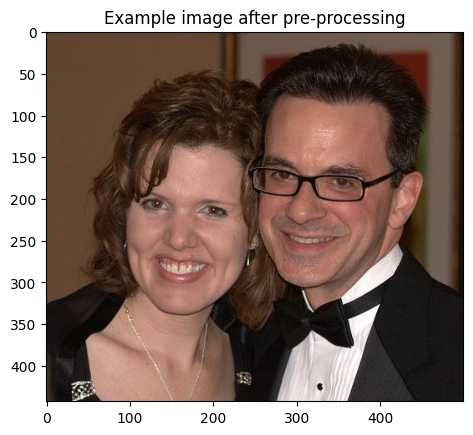

tensor([[   0,    3,  133,    7, 1637,   68,    3, 1299,   43,  486, 1149,   14,
          131,   20,  130,  861,  862,   59,  525,   14,   21,  314,    7,  106,
            3,   43, 2536,   10,    3, 1608,  486,   14,   88,  174,   32,    2,
          282,   49,  333,   59,    7,  106,  579,   43, 1187, 1851,   14,   21,
          187,  174,    8,    3,   43,    2,   63,   10,  156,   59, 2842,    2,
           33,  413,    7,  183,  106,    3, 2007,   59, 2200,   87,   20,  183,
          156,   14,  409,  333,    7, 2191,  967,   59,   49,   33,  413,    7,
          106,    2,    2,   14,   21,  240,   31,   21,  207,    7, 1062,  197,
           59,  174,    3, 1674, 1432,  644,    8,   13,   14,    1]])


In [ ]:

img_original,image, captions = next(iter(te_load))
plt.imshow(np.squeeze(img_original))
plt.title('Example image after pre-processing')
plt.show()
print(captions)

In [ ]:
captions =captions.tolist()
captions = captions[0]
print(captions)
print([data_loader.dataset.vocab.idx2word[x] for x in captions])

[0, 3, 133, 7, 1637, 68, 3, 1299, 43, 486, 1149, 14, 131, 20, 130, 861, 862, 59, 525, 14, 21, 314, 7, 106, 3, 43, 2536, 10, 3, 1608, 486, 14, 88, 174, 32, 2, 282, 49, 333, 59, 7, 106, 579, 43, 1187, 1851, 14, 21, 187, 174, 8, 3, 43, 2, 63, 10, 156, 59, 2842, 2, 33, 413, 7, 183, 106, 3, 2007, 59, 2200, 87, 20, 183, 156, 14, 409, 333, 7, 2191, 967, 59, 49, 33, 413, 7, 106, 2, 2, 14, 21, 240, 31, 21, 207, 7, 1062, 197, 59, 174, 3, 1674, 1432, 644, 8, 13, 14, 1]
['<start>', 'a', 'couple', 'is', 'posing', 'at', 'a', 'formal', 'black', 'tie', 'event', '.', 'they', 'are', 'both', 'enjoying', 'themselves', 'and', 'smiling', '.', 'the', 'man', 'is', 'wearing', 'a', 'black', 'tuxedo', 'with', 'a', 'bow', 'tie', '.', 'he', 'has', 'short', '<unk>', 'back', 'brown', 'hair', 'and', 'is', 'wearing', 'square', 'black', 'frame', 'eyeglasses', '.', 'the', 'woman', 'has', 'on', 'a', 'black', '<unk>', 'top', 'with', 'silver', 'and', 'crystal', '<unk>', ',', 'she', 'is', 'also', 'wearing', 'a', 'necklace',

In [ ]:
wor_caps = [data_loader.dataset.vocab.idx2word[token] for token in captions]
str_cap = ' '.join(wor_caps)
print(str_cap)

<start> a couple is posing at a formal black tie event . they are both enjoying themselves and smiling . the man is wearing a black tuxedo with a bow tie . he has short <unk> back brown hair and is wearing square black frame eyeglasses . the woman has on a black <unk> top with silver and crystal <unk> , she is also wearing a necklace and earrings that are also silver . her hair is chin length and brown , she is wearing <unk> <unk> . the wall in the background is painted tan and has a framed painting hung on it . <end>


In [ ]:
cap_list = str_cap.split('.')
cap_list = [cap.strip() for cap in cap_list if cap.strip()]
for num_c, cap in enumerate(cap_list, start=1):
    print(f"caption {num_c}: {cap}")

caption 1: <start> a couple is posing at a formal black tie event
caption 2: they are both enjoying themselves and smiling
caption 3: the man is wearing a black tuxedo with a bow tie
caption 4: he has short <unk> back brown hair and is wearing square black frame eyeglasses
caption 5: the woman has on a black <unk> top with silver and crystal <unk> , she is also wearing a necklace and earrings that are also silver
caption 6: her hair is chin length and brown , she is wearing <unk> <unk>
caption 7: the wall in the background is painted tan and has a framed painting hung on it
caption 8: <end>


In [ ]:
# %load_ext autoreload
# %autoreload 2

# sz_embed = 128
# sz_hidden_state = 256
# #should be mathing from above value (up)
# path_mod_encoder = 'encoder-25.pkl'
# path_mod_decoder = 'decoder-25.pkl'
# encoder = Encoder_CNN(sz_embed)
# decoder = Decoder_RNN(sz_embed, sz_hidden_state, len_myvocab)
encoder.eval()
decoder.eval()


# encoder.load_state_dict(torch.load(os.path.join('./models', path_mod_encoder),  map_location='cpu'))
# decoder.load_state_dict(torch.load(os.path.join('./models', path_mod_decoder),  map_location='cpu'))

decoder.to(device)
encoder.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Encoder_CNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [ ]:
image = image.to(device)

def imshow(arg, img_name=None):
    loc_m = np.array([0.485, 0.456, 0.406])
    loc_s = np.array([0.229, 0.224, 0.225])
    arg = arg.numpy().transpose((1, 2, 0))
    arg = loc_s * arg + loc_m
    arg = np.clip(arg, 0, 1)
    plt.imshow(arg)
    if img_name is not None:
        plt.title(img_name)
    plt.pause(0.001)
cpu_img = image.cpu()


unnormalize = T.Normalize(mean=[-i/j for i, j in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
                          std=[1/j for j in [0.229, 0.224, 0.225]])

cpu_img_un = unnormalize(cpu_img.squeeze(0))

features = encoder(image).unsqueeze(1)
features = features.to(device)
d_o = decoder.sample(features)
print('example output vocab ids:', d_o)
print('example output tokens:', [data_loader.dataset.vocab.idx2word[o] for o in d_o])

example output vocab ids: [0, 3, 314, 59, 187, 20, 124, 80, 68, 1188, 732, 14, 21, 314, 7, 106, 3, 986, 33, 318, 59, 486, 14, 21, 187, 7, 106, 3, 43, 63, 10, 3, 49, 71, 928, 409, 985, 14, 413, 7]
example output tokens: ['<start>', 'a', 'man', 'and', 'woman', 'are', 'standing', 'outside', 'at', 'night', 'time', '.', 'the', 'man', 'is', 'wearing', 'a', 'sweater', ',', 'shirt', 'and', 'tie', '.', 'the', 'woman', 'is', 'wearing', 'a', 'black', 'top', 'with', 'a', 'brown', 'strap', 'across', 'her', 'shoulder', '.', 'she', 'is']


In [ ]:


list_cap_ref = []
list_cap_gen = []
i =0
for img_original, img, caps in te_load:
    img = img.to(device)
    caps =caps.tolist()
    caps = caps[0]
    wor_caps = [data_loader.dataset.vocab.idx2word[token] for token in caps]
    str_cap = ' '.join(wor_caps)
    list_cap_ref.append(str_cap)
    features = encoder(img).unsqueeze(1)
    features = features.to(device)
    d_o = decoder.sample(features)

    words_d_o = [data_loader.dataset.vocab.idx2word[o] for o in d_o]
    str_d_o = ' '.join(words_d_o)
    list_cap_gen.append(str_d_o)
    print(i)
    print("Caption:",str_cap)
    print("Generated:",str_d_o)
    i = i + 1
    # if i==50:
    #   break
# cider_score=CiderScorer().compute_score(list_cap_ref, list_cap_gen)
# print("CIDEr score:", cider_score)

is invoked
0
Caption: <start> this is an image of a laptop . the laptop is being cut by knives . the knives have black handles . the knives have silver blades . the laptop is black at the bottom . there are <unk> on the back of the laptop . the <unk> are different various types . there are two hands holding knives . the one wrist has a silver watch one it . <end>
Generated: <start> a train riding on the bridge . the train is dark red . there is a red cap and a red . there is a white car behind the bridge . the sky is blue and the front of
is invoked
1
Caption: <start> a crowd of people is sitting in a stand watch a man in red and white ski with two ski poles in his hand . the man has on a hat and the number <unk> in the middle of his shirt , there is also some writing on his shirt . there is some writing on the wall by the people in the stands . there is a pole in the middle of the people . <end>
Generated: <start> a man is skateboarding . the man is holding the skateboard with his rig

In [ ]:
!pip install rouge

from rouge import Rouge

# Assuming list_cap_ref and list_cap_gen are lists of reference and generated captions, respectively

rouge = Rouge()
scores = rouge.get_scores(list_cap_gen, list_cap_ref)

# ROUGE-L scores
rouge_l_precision = scores[0]['rouge-l']['p']
rouge_l_recall = scores[0]['rouge-l']['r']
rouge_l_fmeasure = scores[0]['rouge-l']['f']

print("ROUGE-L Precision:", rouge_l_precision)
print("ROUGE-L Recall:", rouge_l_recall)
print("ROUGE-L F-measure:", rouge_l_fmeasure)
print(list_cap_gen)
print(list_cap_ref)


ROUGE-L Precision: 0.35
ROUGE-L Recall: 0.1891891891891892
ROUGE-L F-measure: 0.24561403053247163
